## Preprocessing

In [4]:
import cv2
import os
import numpy as np

# Define paths
input_base = "dataset"  # Original dataset folder
output_base = "operatorDataset"  # New preprocessed dataset folder

categories = ["add", "subtract", "multiply", "divide"]
subsets = ["train", "test", "valid"]

# Create output directory structure
for subset in subsets:
    for category in categories:
        os.makedirs(os.path.join(output_base, subset, category), exist_ok=True)

def preprocess_image(image_path):
    """ Preprocess image to 28x28 format """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)
    
    # Find bounding box
    y_indices, x_indices = np.where(binary > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        cropped = binary[y_min:y_max+1, x_min:x_max+1]
    else:
        return None  # Skip empty images
    
    # Resize while maintaining aspect ratio
    h, w = cropped.shape
    aspect_ratio = w / h
    if aspect_ratio > 1:
        new_w, new_h = 20, int(20 / aspect_ratio)
    else:
        new_h, new_w = 20, int(20 * aspect_ratio)
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Center in 28x28 black background
    final_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return final_img

# Process all images
for subset in subsets:
    for category in categories:
        input_folder = os.path.join(input_base, subset, category)
        output_folder = os.path.join(output_base, subset, category)
        
        for img_name in os.listdir(input_folder):
            img_path = os.path.join(input_folder, img_name)
            processed_img = preprocess_image(img_path)
            
            if processed_img is not None:
                output_path = os.path.join(output_folder, img_name)
                cv2.imwrite(output_path, processed_img)

print("Preprocessing complete. Images saved in 'operatorDataset'.")


Preprocessing complete. Images saved in 'operatorDataset'.


## Training operator dataset

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define dataset path
data_dir = "operatorDataset"
categories = ["add", "subtract", "multiply", "divide"]
img_size = 28

# Load images and labels
def load_data(subset):
    images, labels = [], []
    for label, category in enumerate(categories):
        folder = os.path.join(data_dir, subset, category)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img / 255.0  # Normalize to [0,1]
                images.append(img.reshape(img_size, img_size, 1))
                labels.append(label)
    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_data("train")
X_test, y_test = load_data("test")

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Define CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),  
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),  
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dense(4, activation='softmax')  # 4 classes (add, subtract, multiply, divide)
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

D:\Sem - 6\Minor 2\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9228 - loss: 0.2431 - val_accuracy: 0.9940 - val_loss: 0.0181
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9946 - loss: 0.0196 - val_accuracy: 0.9914 - val_loss: 0.0160
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9963 - loss: 0.0138 - val_accuracy: 0.9967 - val_loss: 0.0075
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9966 - loss: 0.0097 - val_accuracy: 0.9967 - val_loss: 0.0075
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9974 - val_loss: 0.0074
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9980 - loss: 0.0053 - val_accuracy: 0.9967 - val_loss: 0.0073
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 0.9980 - val_loss: 0.0037
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accu

In [7]:
# Save model
model.save("operator_model.h5")
print("Training complete! Model saved as 'operator_model.h5'")

Training complete! Model saved as 'operator_model.h5'


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

# Load trained model
model_path = "operator_model.h5"
model = load_model(model_path)

# Recompile model (use same settings as during training)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define test dataset path
test_dir = "operatorDataset/test"

# Define class labels (ensure order matches your training labels)
class_labels = ["add", "subtract", "multiply", "divide"]

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (28, 28))  # Resize to match model input
    img = img / 255.0  # Normalize
    img = img.reshape(28, 28, 1)  # Reshape for CNN
    return img

# Load and preprocess all test images
X_test = []
y_true = []

for label_idx, label in enumerate(class_labels):
    folder_path = os.path.join(test_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = preprocess_image(img_path)
        
        X_test.append(img)
        y_true.append(label_idx)

# Convert to NumPy arrays
X_test = np.array(X_test)
y_true = np.array(y_true)

# Predict all at once (much faster)
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred == y_true) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
Test Accuracy: 99.80%


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  

Classification Report:
              precision    recall  f1-score   support

         add       0.99      1.00      1.00       355
    subtract       1.00      1.00      1.00       432
    multiply       1.00      0.99      1.00       395
      divide       1.00      1.00      1.00       330

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



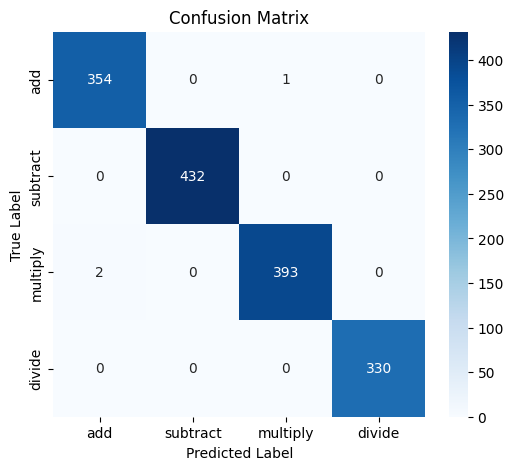

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load trained model
model_path = "operator_model.h5"
model = load_model(model_path)

# Recompile model (use same settings as during training)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define test dataset path
test_dir = "operatorDataset/test"

# Define class labels
class_labels = ["add", "subtract", "multiply", "divide"]

# Check if test dataset exists
if not os.path.exists(test_dir):
    raise ValueError("Test dataset directory does not exist!")

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Couldn't read image {img_path}")
        return None
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img = img.reshape(28, 28, 1)
    return img

# Load and preprocess test images
X_test = []
y_true = []

for label_idx, label in enumerate(class_labels):
    folder_path = os.path.join(test_dir, label)

    if not os.path.exists(folder_path):
        print(f"Warning: Test folder missing for class '{label}'")
        continue

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = preprocess_image(img_path)

        if img is not None:
            X_test.append(img)
            y_true.append(label_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_true = np.array(y_true)

# Ensure dataset is not empty before proceeding
if len(X_test) == 0 or len(y_true) == 0:
    raise ValueError("No valid test images found!")

# Predict all images at once
y_pred = np.argmax(model.predict(X_test), axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Real time testing

In [ ]:
import cvzone
import cv2
import numpy as np
from cvzone.HandTrackingModule import HandDetector
from tensorflow.keras.models import load_model

# Load the trained operator recognition model
model_path = "operator_model.h5"  # Update this with the actual path
model = load_model(model_path)

# Define operator labels
class_labels = ["add", "sub", "mul", "divide"]

# Initialize Video Capture
cap = cv2.VideoCapture(0)

# Hand Detector
detector = HandDetector(staticMode=False, maxHands=1, modelComplexity=1, detectionCon=0.5, minTrackCon=0.5)

def getHandInfo(img):
    hands, img = detector.findHands(img, draw=True, flipType=True)
    if hands:
        hand = hands[0]  # Get the first detected hand
        lmList = hand["lmList"]  # List of 21 landmarks
        fingers = detector.fingersUp(hand)
        return fingers, lmList
    return None

def draw(info, prev_pos, canvas):
    fingers, lmList = info
    current_pos = None 
    if fingers == [0, 1, 0, 0, 0]:  # Index finger up
        current_pos = lmList[8][0:2]  # Index finger tip coordinates
        if prev_pos is None: 
            prev_pos = current_pos
        cv2.line(canvas, tuple(current_pos), tuple(prev_pos), (255, 255, 255), 10)  # White color for high contrast
    return current_pos, canvas

def preprocess_for_prediction(canvas):
    """ Preprocess the drawn image for model prediction. """
    gray_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_canvas, 50, 255, cv2.THRESH_BINARY)
    
    y_indices, x_indices = np.where(binary > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        cropped = binary[y_min:y_max+1, x_min:x_max+1]
    else:
        return None  # No valid drawing detected
    
    # Resize while keeping aspect ratio
    h, w = cropped.shape
    aspect_ratio = w / h

    if aspect_ratio > 1:
        new_w = 20
        new_h = int(20 / aspect_ratio)
    else:
        new_h = 20
        new_w = int(20 * aspect_ratio)

    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Center in a 28x28 frame
    final_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    # Normalize and reshape for model input
    final_img = final_img / 255.0
    final_img = final_img.reshape(1, 28, 28, 1)

    return final_img

prev_pos = None
canvas = None
predicted_operator = None

while True:
    success, img = cap.read()
    img = cv2.flip(img, 1)  # Mirror effect for a natural drawing experience
    
    if canvas is None:
        canvas = np.zeros_like(img)

    info = getHandInfo(img)
    if info:
        fingers, lmList = info
        
        # Clear canvas when all 5 fingers are up
        if fingers == [1, 1, 1, 1, 1]:  
            canvas = np.zeros_like(img)
            prev_pos = None
            predicted_operator = None
            print("Canvas Cleared (All 5 Fingers Up)")

        # Predict operator when 2nd & 5th fingers are up
        if fingers == [0, 1, 0, 0, 1]:
            processed_img = preprocess_for_prediction(canvas)
            if processed_img is not None:
                prediction = model.predict(processed_img)
                predicted_class = np.argmax(prediction)
                predicted_operator = class_labels[predicted_class]
                confidence = np.max(prediction) * 100
                print(f"Predicted: {predicted_operator} ({confidence:.2f}%)")

        prev_pos, canvas = draw(info, prev_pos, canvas)

    # Overlay canvas on image
    image_combined = cv2.addWeighted(img, 0.7, canvas, 0.3, 0)

    # Display prediction on screen
    if predicted_operator is not None:
        cv2.putText(image_combined, f'Predicted: {predicted_operator}', 
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    
    # Show windows
    cv2.imshow("Canvas", canvas)
    cv2.imshow("Operator Recognition", image_combined)

    # Quit when 'Q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: add (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: add (1